# Using a Recommender System for ill-defined Chemical Systems

> This notebook shows how to build a simple collaborative filtering model for prediction of polymer solubility using the fastai library.
- toc: True
- metadata_key1: collaborative filtering
- metadata_key2: solubility
- metadata_key3: machine learning

Polymer systems are usually not well defined, in the sense that only the basic chemistry is known and specified, but neither the processing conditions nor the exact structure or end group chemistry is given. They are intrisically mixtures represented by a molecular weight distribution. This fact hampers any thorough description by molecular descriptors in order to develop predictive models. 

The following notebook develops a predictive model for polymer solubilities in different solvents using a recommender system, without the need to use any pre-computed descriptors.

Recommender systems are well-known for describing user-item relationships such as movie recommendations. Usually a matrix of user ratings given by various users on different movies (items) is used to predict ratings for unseen movies. 

|          | Movie1| Movie2 | Movie3 |$\ldots$ |MovieM|
| ------------- |:-------------:| -----:| -----:|-----:|---:|
| user1         | 5 | 3 |  || 4 |
| user2         | 1 | 3 | 3 ||  |
| user3         | 2 | 3 |  || 4 |
| $\vdots$      |   |   |  ||   | 
| userN         | 5 | 2 | 3 || 2 |

In this notebook we apply the same kind of model for prediction of polymer solubilities in typical solvents. In a way we treat the solvents as users and the polymers as movies, though this choice could have been interchanged.


|          | Polymer1| Polymer2 | Polymer3 |$\ldots$ |PolymerM|
| ------------- |:-------------:| -----:| -----:|-----:|---:|
| Solvent1         | 5 | 3 |  || 4 |
| Solvent2         | 1 | 3 | 3 ||  |
| Solvent3         | 2 | 3 |  || 4 |
| $\vdots$      |   |   |  ||   | 
| SolventN         | 5 | 2 | 3 || 2 |


The basic idea is to use so-called embeddings for both solvent and polymers that are automatically learned by predicting solubilities by gradient-descent on a suitable loss function (such as root mean squared error) and subsequent backpropagation. Those embeddings map each polymer and solvent in a characteristic position in a n-dimensional vector space, which  corresponds to some kind of self-learnd feature space.

## Matrix factorization

$\textbf{R} = \textbf{U} \times \textbf{I}$

This is basically done by learning the [matrix factorisation](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)) of the Solvent ($\textbf{U}$) and Polymer ($\textbf{I}$) embeddings from the experimental data / solubility rating ($\textbf{R}$) via the deep learning frameworks pytorch & fastai.

## Correlation with Chemical Descriptors

Finally we are [comparing the learned embeddings / features](#Correlation-of-Learned-Embeddings-with-RDKit-descriptors) with typical chemical descriptors computed with the RDKit library.



Loading python libraries for the notebook. We are using the [fastai](https://docs.fast.ai/) library and [pytorch](https://pytorch.org/).

In [26]:
import os

from fastai.collab import *
from fastai.tabular import *
from torch.nn import L1Loss,MSELoss

import pandas as pd
import seaborn as sns

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Loading solubilities of 33 industrial grade polymers in 88 typical solvents extraced from the Doctoral Thesis of Charles Hansen "The Three Dimensional Solubility Parameter", Danish Technical Press, 1967.
The rating is from 1: fullly soluble to 6: insoluble in the respective solvent.

In [2]:
url = 'https://github.com/CHLoschen/CHLoschen.github.io/blob/master/data/Hansen_polymer_data_upload.xlsx?raw=true'
df = pd.read_excel(url,sheet_name='hansen_thesis_polymers_curated',index_col=0)
df.head()

,orig_nr,Solvent,A,B,C,D,E,F,G,H,...,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH
nr,,,,,,,,,,,,,,,,,,,,,
1,1,Methanol,5,6.0,4,5,4,5,6,1,...,6,5,6,1,6,5,6,6,6,5.0
2,2,Ethanol 96%,4,6.0,4,6,4,1,6,1,...,6,5,5,1,6,5,6,6,6,5.0
3,3,Ethanol 99%,5,6.0,3,5,1,1,6,4,...,6,6,4,1,6,5,6,6,6,6.0
4,4,n-Propanol,5,6.0,3,5,1,1,6,4,...,5,1,5,1,6,4,6,6,6,6.0
5,5,n-Butanol,5,6.0,3,5,1,1,6,5,...,5,1,3,1,6,4,6,6,6,6.0


In [3]:
value_columns = list(df.columns)
value_columns.remove('Solvent')
value_columns.remove('orig_nr')
df[value_columns] = df[value_columns].astype(np.float32)

Converting dataframe from a long format to a wide format, which is necessary as an input for the fastai CollabLearner Class.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89ca4284e0>]], dtype=object)

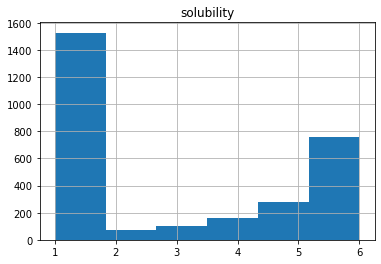

In [4]:
# melting a dataframe from wide to long
# 1_soluble 6: mno visible effect
df_long = pd.melt(df, id_vars=['Solvent'], value_vars=value_columns, var_name='polymer',value_name='solubility')
df_long.describe()
df_long.hist(bins=6)

In [5]:
df_long

,Solvent,polymer,solubility
0,Methanol,A,5.0
1,Ethanol 96%,A,4.0
2,Ethanol 99%,A,5.0
3,n-Propanol,A,5.0
4,n-Butanol,A,5.0
...,...,...,...
2899,Acetic acid,AH,4.0
2900,Formic acid 90%,AH,1.0
2901,Butyric acid,AH,6.0
2902,Benzaldehyde,AH,3.0


In [6]:
#df_long = df_long.loc[~df_long['solubility'].isna()]
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2904 entries, 0 to 2903
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Solvent     2904 non-null   object 
 1   polymer     2904 non-null   object 
 2   solubility  2896 non-null   float32
dtypes: float32(1), object(2)
memory usage: 56.8+ KB


In [7]:
df_names = pd.read_excel(url,sheet_name='polymers',header=None)
df_names.columns=['polymer','all','fullname']
df_names.head()

,polymer,all,fullname
0,A,"Lucite'""' 2042-poly (ethyl methacrylate), E. I...",poly (ethyl methacrylate)
1,B,"Poly (methyl methacrylate), Rohm and Haas Co.",Poly (methyl methacrylate)
2,C,"Epikote® lOOI-epoxy, Shell Chemical Co.",Epikote epoxy
3,D,"Plexal P65-66 “4 oil length alkyd, Polyplex.",Plexal alkyd
4,E,"Pentalyn'*' 830-alcohol soluble rosin resin, H...",alcohol soluble resin 830


In [8]:
df_long = df_long.merge(df_names,left_on='polymer',right_on='polymer')
df_long = df_long.rename({'polymer':'short','fullname':'polymer'},axis=1)


In [9]:
df_long= df_long.loc[~df_long['solubility'].isna()]

In [11]:
data = CollabDataBunch.from_df(df_long, bs=32, user_name='Solvent', item_name='polymer',rating_name='solubility' ,seed=42)

In [12]:
top_polymers = np.asarray(list(set(df_long['polymer'])))
top_solvents = df['Solvent'].values # original order

Defining the loss functions (mean squared error) used to optimized the weights.

In [13]:
lossf = MSELossFlat()

Finally we are using 5 features for each solvent and each polymer and a sigmoidal function to squash the final values to a range between $[0.75,6.25]$.

In [14]:

y_range = [0.75,6.25] # best range
#y_range = None
#learn = collab_learner(data, n_factors=3, y_range=y_range,metrics=[rmse,mse], wd=1e-1)
#learn = collab_learner(data, n_factors=4, y_range=y_range,metrics=[rmse,mse], wd=1e-1,loss_func = lossf)
learn = collab_learner(data, n_factors=5, y_range=y_range,metrics=[rmse,mse], wd=1e-1)
#learn = collab_learner(data, n_factors=4, y_range=y_range,use_nn=True, layers=[512],)
#learn = collab_learner(data,use_nn=True, emb_szs={'Solvent': 10, 'polymer':10}, layers=[32], y_range=y_range)
#learn

In [15]:
learn.fit_one_cycle(5, max_lr=1.0e-1) # BEST RMSE=1.09

epoch,train_loss,valid_loss,root_mean_squared_error,mean_squared_error,time
0,3.880454,2.393616,1.522278,2.393616,00:00
1,2.349662,1.822205,1.330019,1.822205,00:00
2,1.692601,1.492420,1.205951,1.492420,00:00
3,1.213818,1.371374,1.153695,1.371374,00:00
4,0.882867,1.348545,1.146253,1.348545,00:00


In [18]:
learn.fit_one_cycle(20, max_lr=1.5e-2) # BEST RMSE=1.09

epoch,train_loss,valid_loss,root_mean_squared_error,mean_squared_error,time
0,0.498794,1.250511,1.099317,1.250511,00:00
1,0.507875,1.251159,1.099401,1.251159,00:00
2,0.544147,1.256568,1.101957,1.256568,00:00
3,0.573578,1.246693,1.097359,1.246692,00:00
4,0.601933,1.265147,1.105491,1.265147,00:00
5,0.598190,1.250596,1.098781,1.250596,00:00
6,0.607573,1.273278,1.108370,1.273278,00:00
7,0.595005,1.252546,1.098373,1.252546,00:00
8,0.587067,1.260029,1.101490,1.260029,00:00
9,0.577163,1.248523,1.097305,1.248523,00:00


## Some Notes

Those are just some notes from differemt optimization runs to find the best parameters.

|epoch|	train_loss	|valid_loss	|root_mean_squared_error|	mean_squared_error|time|
|-|-|-|-|-|-|
|9	|0.864711	|1.437362	|1.183305	|1.437362	|00:30 |embedding=5 no NN no range|
|9	|0.567250	|1.571942	|1.240355	|1.571942	|00:30 |embedding=10 no NN no range|
|9	|0.382161	|1.630874	|1.257383	|1.630875	|00:31 |embedding=20 no NN no range|
|9	|0.600861	|1.346427	|1.144532	|1.346427	|00:31 |embedding=4 range & wd|
|4	|0.446523	|1.271633	|1.113335	|1.271633	|00:30 |embedding=4 range & wd|
|4	|0.601325	|1.305175	|1.128294	|1.305175	|00:30 |embedding=5 range & wd|
|9	|0.594458	|1.223412	|1.095868	|1.223412	|00:30 |collab_learner(data, n_factors=4, y_range=y_range, wd=1e-1)|

Best results: rmse = 1.11


In [27]:
learn.save('polymer')
learn.export()

In [29]:
learn.load('polymer');

   # Results

In [30]:
learn = load_learner('.', test=data.valid_ds.x)

In [31]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)
data.valid_ds

LabelList (579 items)
x: CollabList
Solvent 2-Nitropropane ; polymer Poly (methyl methacrylate); ,Solvent 2-Butoxyethanol ; polymer furfuryl alcohol resin; ,Solvent  Butyric acid    ; polymer styrene-butadiene (SBR); ,Solvent Mesityl oxide; polymer styrene-butadiene (SBR); ,Solvent Formic acid 90%; polymer isoprene; 
y: FloatList
1.0,1.0,4.0,1.0,6.0
Path: .

In [33]:
data.valid_ds.y[0].data
y_true = np.asarray([t.data for t in data.valid_ds.y])
solvents = [t for t in data.valid_ds.x]
tmp = solvents[0]
tmp

CollabLine Solvent 2-Nitropropane ; polymer Poly (methyl methacrylate); 

Visualization of the final predictions on the validation data set.

Bad und good solvent are identified quite well with some outliers mainly for high solubility.

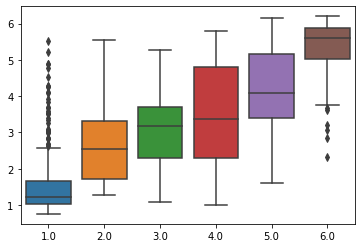

In [34]:
sns.boxplot(y_true,preds.numpy())

In [35]:
df_long.head()

,Solvent,short,solubility,all,polymer
0,Methanol,A,5.0,"Lucite'""' 2042-poly (ethyl methacrylate), E. I...",poly (ethyl methacrylate)
1,Ethanol 96%,A,4.0,"Lucite'""' 2042-poly (ethyl methacrylate), E. I...",poly (ethyl methacrylate)
2,Ethanol 99%,A,5.0,"Lucite'""' 2042-poly (ethyl methacrylate), E. I...",poly (ethyl methacrylate)
3,n-Propanol,A,5.0,"Lucite'""' 2042-poly (ethyl methacrylate), E. I...",poly (ethyl methacrylate)
4,n-Butanol,A,5.0,"Lucite'""' 2042-poly (ethyl methacrylate), E. I...",poly (ethyl methacrylate)


In [36]:
datatest = CollabList.from_df(df_long,cat_names=['Solvent','polymer'],cont_names=['solubility'])
learn.data.add_test(datatest) 
preds, _ = learn.get_preds(ds_type = DatasetType.Test)

In [37]:
df_long['predictions'] = preds.numpy()
df_long['SE'] = np.fabs(df_long['solubility'] - df_long['predictions'])
df_long['SE_mean'] = df_long.groupby('polymer')['SE'].transform(np.mean)

In [38]:
df_long.sort_values('SE',ascending=False).head(20)

,Solvent,short,solubility,all,polymer,predictions,SE,SE_mean
679,Carbon tetrachloride,H,1.0,"Mowilith®50-poly (vinyl acetate), Farbwerke Ho...",poly (vinyl acetate),5.527270,4.527270,0.648882
1774,m-Cresol,U,1.0,Hycar®' lO52-acrylonitrile-butadiene raw elast...,acrylonitrile-butadiene,5.219611,4.219611,0.641831
2297,Propylene glycol,AB,1.0,"Cymel "" 300-hexamethoxy melamine, American Cya...",hexamethoxy melamine,4.897994,3.897994,0.411346
1202,Dipropyl amine,N,1.0,"Phenodur 373U-phenol-resol resin, Chemische We...",phenol-resol resin,4.893676,3.893676,0.765612
95,2-Ethyl hexanol,B,2.0,"Poly (methyl methacrylate), Rohm and Haas Co.",Poly (methyl methacrylate),5.793727,3.793727,0.753604
1112,Ethanolamine,M,1.0,"Super Beckacite'® JOOI-Pure Phenolic Resin, Re...",Phenolic Resin,4.785949,3.785949,0.443935
1195,Nitromethane,N,6.0,"Phenodur 373U-phenol-resol resin, Chemische We...",phenol-resol resin,2.324368,3.675632,0.765612
94,2-Ethyl butanol,B,2.0,"Poly (methyl methacrylate), Rohm and Haas Co.",Poly (methyl methacrylate),5.592360,3.592360,0.753604
1492,Formic acid 90%,Q,2.0,"Suprasec F5100-blocked isocyanate (phenol), Im...",isocyanate (phenol),5.545220,3.545220,0.610754
2742,m-Cresol,AG,1.0,"Piccoumarone 450L-cumarone-indene resin, Penns...",cumarone-indene resin,4.539486,3.539486,0.359633


In [39]:
df_long.loc[df_long['polymer'] == 'Nitrocellulose'].sort_values('SE',ascending=False).head(20)

,Solvent,short,solubility,all,polymer,predictions,SE,SE_mean
820,Dioxane,J,6.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,2.914037,3.085963,0.612327
803,"1,3 Butanediol",J,6.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,3.071082,2.928918,0.612327
862,"2,2-Dichlorodiethylether",J,5.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,2.354406,2.645594,0.612327
839,Isoamyl acetate,J,1.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,3.595124,2.595124,0.612327
846,Aniline,J,3.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,1.085439,1.914561,0.612327
840,Isobutyl isobutyrate,J,1.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,2.814014,1.814014,0.612327
831,Diisobutyl ketone,J,1.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,2.727038,1.727038,0.612327
847,Nitrobenzene,J,1.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,2.381097,1.381097,0.612327
793,Ethanol 96%,J,6.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,4.674847,1.325153,0.612327
878,Benzaldehyde,J,1.0,"% Sec. Nitrocellulose-!! 23, A. Hagedorn and C...",Nitrocellulose,2.310237,1.310237,0.612327


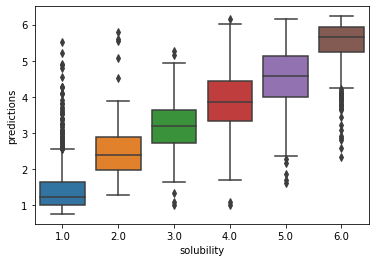

In [40]:
sbn.boxplot(df_long['solubility'],df_long['predictions'])

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(df_long['solubility'],df_long['predictions'])
rmse = mean_squared_error(df_long['solubility'],df_long['predictions'])**0.5
print("MAE: {:6.4f} RMSE: {:6.3f}".format(mae,rmse))

MAE: 0.5297 RMSE:  0.781


   # Interpretation

   Here we try to interpret the learned embeddings, in particular if they correspond to some physicochemical properties and/or descriptors.

In [43]:
learn.load('polymer');

In [44]:
polymer_bias = learn.bias(top_polymers, is_item=True)
polymer_bias.shape

torch.Size([33])

In [45]:
mean_ratings = df_long.groupby('polymer')['solubility'].mean()
polymer_ratings = [(b.item(), i, mean_ratings.loc[i]) for i,b in zip(top_polymers,polymer_bias)]

In [46]:
item0 = lambda o:o[0]

In [47]:
sorted(polymer_ratings, key=item0)[:15]

[(-1.511541724205017, 'Polyester', 1.6896552),
 (-1.458953857421875, 'Phenolic Resin', 1.3295455),
 (-1.4562469720840454, 'hexamethoxy melamine', 1.2613636),
 (-1.1389750242233276, 'Plexal alkyd', 1.9090909),
 (-0.8391879200935364, 'coconut oil-phthalic anhydride alkyd', 1.8863636),
 (-0.7986485362052917, 'pentaerythritol ester of rosin', 2.034091),
 (-0.6752591729164124, 'alcohol soluble resin 830', 2.0),
 (-0.6638078689575195, 'Epikote epoxy', 2.1363637),
 (-0.6293772459030151, 'Ester gum', 2.1704545),
 (-0.5470041632652283, 'phenol-resol resin', 3.2045455),
 (-0.5220370888710022, 'poly (ethyl methacrylate)', 2.0113637),
 (-0.44126516580581665, 'poly (vinyl acetate)', 2.1363637),
 (-0.3716408312320709, 'akohol soluble resin 255', 2.8181818),
 (-0.36254385113716125, 'furfuryl alcohol resin', 2.7954545),
 (-0.29995399713516235, 'poly (vinyl butyral)', 2.3181818)]

In [48]:
movie_w = learn.weight(top_polymers, is_item=True)
movie_w.shape

torch.Size([33, 5])

In [49]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([33, 3])

In [50]:
fac0,fac1,fac2 = movie_pca.t()
polymer_comp = [(f, i) for f,i in zip(fac0, top_polymers)]

In [51]:
sorted(polymer_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(2.4272), 'terpene resin'),
 (tensor(2.3092), 'petroleum hydrocarbon resin'),
 (tensor(2.0871), 'poIy (isobutylene)'),
 (tensor(1.9997), 'isoprene'),
 (tensor(1.9296), 'cis poly butadiene '),
 (tensor(1.8371), 'styrene-butadiene (SBR)'),
 (tensor(1.4173), 'Polystyrene'),
 (tensor(1.2220), 'cumarone-indene resin'),
 (tensor(1.1789), 'Ester gum'),
 (tensor(0.7506), 'pentaerythritol ester of rosin')]

In [52]:
sorted(polymer_comp, key=itemgetter(0))[:10]

[(tensor(-2.0999), 'phenol-resol resin'),
 (tensor(-1.9046), 'akohol soluble resin 255'),
 (tensor(-1.8175), ' isocyanate (phenol)'),
 (tensor(-1.6700), 'lignin'),
 (tensor(-1.6170), 'Nitrocellulose'),
 (tensor(-1.5084), 'urea formaldehyde resin'),
 (tensor(-1.2535), 'furfuryl alcohol resin'),
 (tensor(-1.2297), 'Polyester'),
 (tensor(-1.1110), 'Cellulose acetate'),
 (tensor(-1.0091), 'poly (vinyl acetate)')]

In [53]:
polymer_comp = [(f, i) for f,i in zip(fac1, top_polymers)]

In [54]:
sorted(polymer_comp, key=itemgetter(0), reverse=False)[:10]

[(tensor(-2.0351), 'polyamide'),
 (tensor(-1.8825), 'poIy (isobutylene)'),
 (tensor(-1.8567), 'poly (vinyl butyral)'),
 (tensor(-1.7696), 'akohol soluble resin 255'),
 (tensor(-1.4629), 'alcohol soluble resin 830'),
 (tensor(-1.4358), 'urea formaldehyde resin'),
 (tensor(-1.0520), 'pentaerythritol ester of rosin'),
 (tensor(-0.7186), 'hexamethoxy melamine'),
 (tensor(-0.7005), 'Ester gum'),
 (tensor(-0.6341), 'Phenolic Resin')]

In [55]:
sorted(polymer_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.4824), 'Nitrocellulose'),
 (tensor(1.3826), 'acrylonitrile-butadiene'),
 (tensor(1.3192), 'Polystyrene'),
 (tensor(1.2893), 'Poly (methyl methacrylate)'),
 (tensor(1.2830), 'poly (vinyl chloride)'),
 (tensor(1.1330), 'chlorinated poly (propylene)'),
 (tensor(0.8796), 'Cellulose acetate'),
 (tensor(0.7444), 'cumarone-indene resin'),
 (tensor(0.6660), 'Polyester'),
 (tensor(0.6078), 'styrene-butadiene (SBR)')]

In [56]:
top_polymers

array(['poly (ethyl methacrylate)', 'poly (vinyl chloride)', 'styrene-butadiene (SBR)', 'urea formaldehyde resin',
       'Nitrocellulose', 'Polystyrene', 'Epikote epoxy', 'poIy (isobutylene)', 'Phenolic Resin', 'terpene resin',
       'petroleum hydrocarbon resin', 'cumarone-indene resin', 'acrylonitrile-butadiene', 'phenol-resol resin',
       'Plexal alkyd', 'pentaerythritol ester of rosin', 'alcohol soluble resin 830', 'cis poly butadiene ',
       'hexamethoxy melamine', 'polyamide', 'isoprene', 'Polyester', 'Cellulose acetate', 'furfuryl alcohol resin',
       'poly (vinyl acetate)', 'lignin', 'coconut oil-phthalic anhydride alkyd', 'chlorinated poly (propylene)',
       'Poly (methyl methacrylate)', ' isocyanate (phenol)', 'poly (vinyl butyral)', 'akohol soluble resin 255',
       'Ester gum'], dtype='<U36')

33


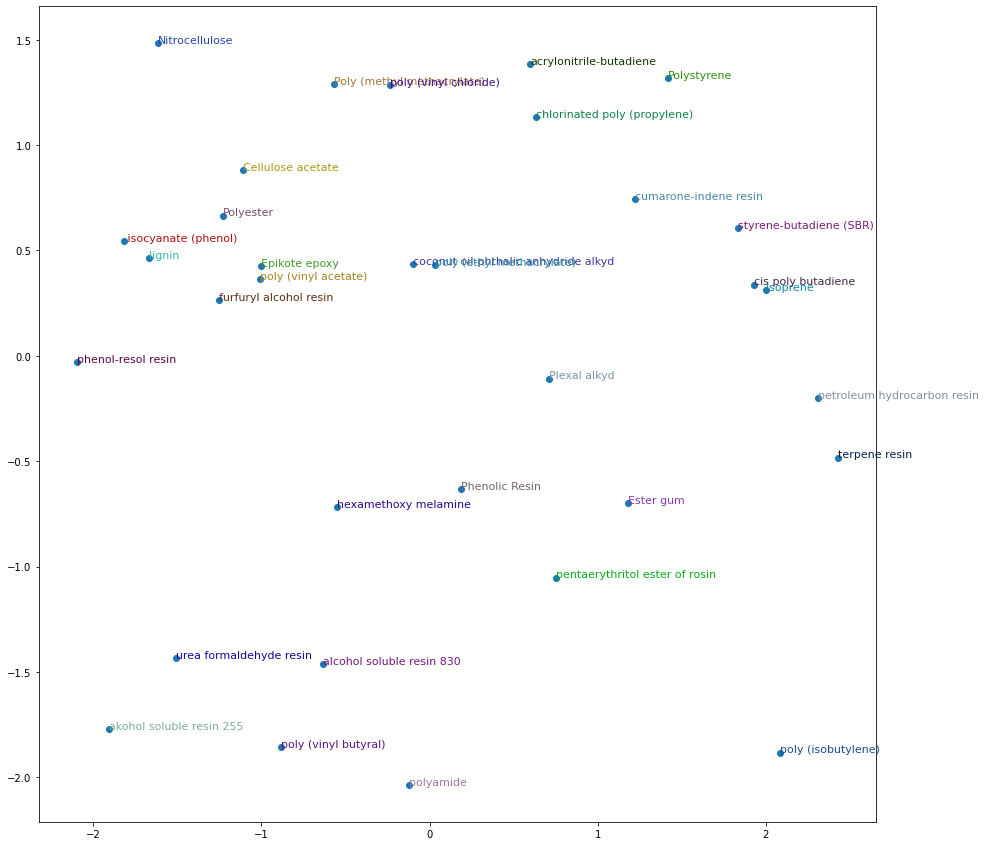

In [57]:
print(len(top_polymers))
idxs = np.random.choice(len(top_polymers), 33, replace=False)

X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_polymers[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

The figure above shows the polymer features space projected onto the 2 main principle components.

## Solvents

In [58]:
print(top_solvents)
solvent_w = learn.weight(top_solvents, is_item=False)
solvent_w.shape

['Methanol ' 'Ethanol 96%' 'Ethanol 99%' 'n-Propanol ' ... 'Formic acid 90%' ' Butyric acid    ' 'Benzaldehyde '
 'Acetic anhydride ']


torch.Size([88, 5])

In [59]:
solvent_pca = solvent_w.pca(3)
solvent_pca.shape

torch.Size([88, 3])

In [60]:
fac0,fac1,fac2 = solvent_pca.t()
solvent_comp = [(f, i) for f,i in zip(fac0, top_solvents)]
sorted(solvent_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.9440), 'Dipropylene glycol'),
 (tensor(1.7700), 'Diethylene glycol'),
 (tensor(1.6478), 'Dimethyl sulphoxide'),
 (tensor(1.3284), 'Acetic acid '),
 (tensor(1.3157), 'Ethyl lactate '),
 (tensor(1.3095), 'Methyl Cellosolve '),
 (tensor(1.2806), 'Ethanolamine   '),
 (tensor(1.2013), 'Methanol '),
 (tensor(1.1993), 'Methyl dioxitol '),
 (tensor(1.1856), 'y-Butyrolactone ')]

In [61]:
sorted(solvent_comp, key=itemgetter(0), reverse=False)[:10]

[(tensor(-1.6316), 'Ethyl benzene '),
 (tensor(-1.5449), 'Benzene     '),
 (tensor(-1.4641), '1,1,1 Trichloroethane'),
 (tensor(-1.3850), 'Isoamyl acetate '),
 (tensor(-1.3618), 'Cyclohexylchloride '),
 (tensor(-1.3517), 'n-Butyl acetate '),
 (tensor(-1.3500), 'Xylene      '),
 (tensor(-1.3242), 'Isobutyl isobutyrate'),
 (tensor(-1.2733), 'Toluene         '),
 (tensor(-1.2611), 'Methylene chloride ')]

88


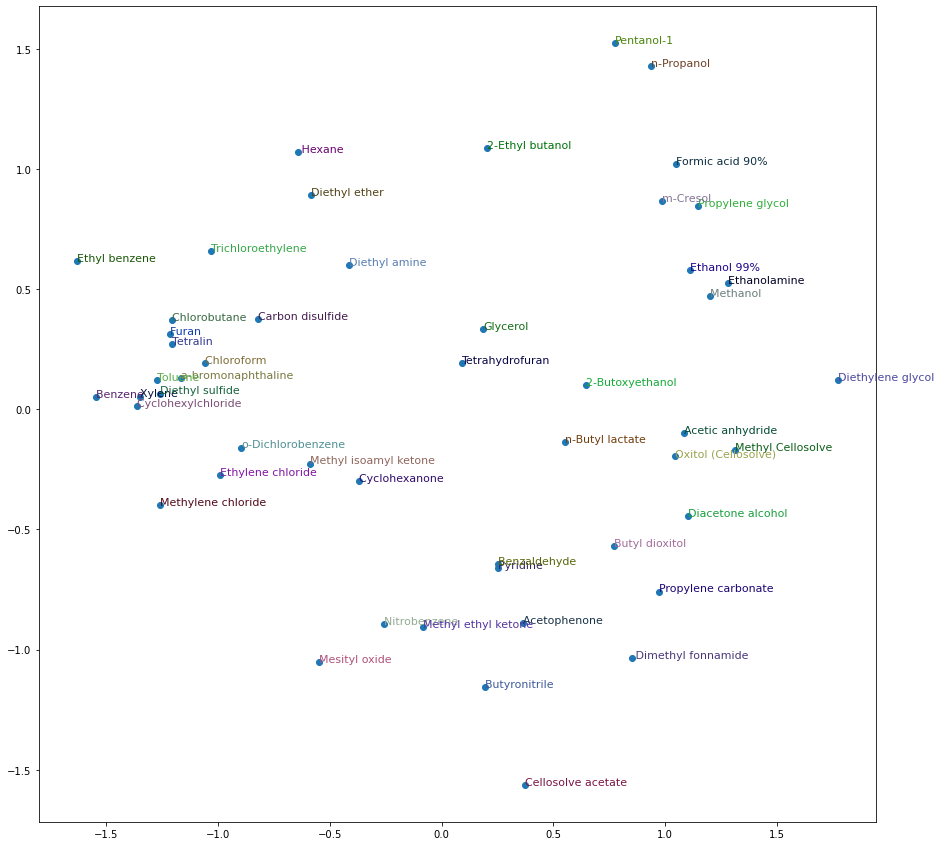

In [62]:
print(len(top_solvents))
idxs = np.random.choice(len(top_solvents), 50, replace=False)

X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_solvents[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

The figure above shows the solvent features space projected onto the 2 main principle components.

# Correlation of Learned Embeddings with RDKit descriptors

First we have to install the cheminformatic package RDKit via conda, which may take some time.

In [63]:
# see also https://iwatobipen.wordpress.com/2018/11/01/run-rdkit-and-deep-learning-on-google-colab-rdkit/
# uncomment those lines below
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [64]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

In [65]:
len(Descriptors._descList)

200

In [66]:
df_desc = pd.read_excel(url,sheet_name='solvent_descriptors')
df_desc

,orig_nr,SMILES,curated_name,original name
0,1,CO,Methanol,Methanol
1,2,CCO,Ethanol,Ethanol 96%
2,3,CCO,Ethanol,Ethanol 99%
3,4,CCCO,n-Propanol,n-Propanol
4,5,CCCCO,n-Butanol,n-Butanol
...,...,...,...,...
83,66,OC(C)=O,Acetic acid,Acetic acid
84,67,OC=O,Formic acid,Formic acid 90%
85,67A,CCCC(=O)O,Butyric acid,Butyric acid
86,68,O=Cc1ccccc1,Benzaldehyde,Benzaldehyde


In [67]:
df_rdkit = df_desc[['SMILES','original name']]
#df_rdkit['MOL'] = df_rdkit['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 
df_rdkit

,SMILES,original name
0,CO,Methanol
1,CCO,Ethanol 96%
2,CCO,Ethanol 99%
3,CCCO,n-Propanol
4,CCCCO,n-Butanol
...,...,...
83,OC(C)=O,Acetic acid
84,OC=O,Formic acid 90%
85,CCCC(=O)O,Butyric acid
86,O=Cc1ccccc1,Benzaldehyde


In [68]:
#https://github.com/rdkit/rdkit/issues/2529
#compute all descriptors for smiles and return dictionary with key: desc_name and value: desc. value
def calc_descrs_for_smiles(smi,descList):
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return dict(zip(descList,[None]*(len(descList))))
    fns = [(x,y) for x,y in Descriptors.descList if x in descList]
    res = {}
    for x,y in fns:
        res[x] = y(m)
    res['SMILES'] = smi
    return res

In [69]:
def compute_corr(df_tmp,threshold=0.4):
    # Compute the correlation matrix
    corr = df_tmp._get_numeric_data().corr()**2
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sbn.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sbn.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return ax,corr

In [70]:
descList = [desc[0] for desc in Descriptors.descList]
desc_corr = ['MinPartialCharge', 'MaxAbsPartialCharge', 'PEOE_VSA6', 'SMR_VSA1','TPSA', 'NOCount', 'NumHAcceptors', 'MolLogP','EState_VSA10', 'NHOHCount', 'NumHDonors', 'fr_Al_OH','fr_Al_OH_noTert','qed']
descList = desc_corr
descList

['MinPartialCharge',
 'MaxAbsPartialCharge',
 'PEOE_VSA6',
 'SMR_VSA1',
 'TPSA',
 'NOCount',
 'NumHAcceptors',
 'MolLogP',
 'EState_VSA10',
 'NHOHCount',
 'NumHDonors',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'qed']

In [71]:
descs=[]
for smi in set(df_rdkit['SMILES'].values):
    res = calc_descrs_for_smiles(smi,descList)
    descs.append(res)


In [72]:
df_rdkit = df_rdkit.merge(pd.DataFrame(descs),left_on='SMILES',right_on='SMILES',how='left')

In [73]:
df_rdkit

,SMILES,original name,qed,MinPartialCharge,MaxAbsPartialCharge,PEOE_VSA6,SMR_VSA1,TPSA,EState_VSA10,NHOHCount,NOCount,NumHAcceptors,NumHDonors,MolLogP,fr_Al_OH,fr_Al_OH_noTert
0,CO,Methanol,0.385284,-0.399630,0.399630,0.000000,5.106527,20.23,0.000000,1,1,1,1,-0.3915,1,1
1,CCO,Ethanol 96%,0.406808,-0.396664,0.396664,0.000000,5.106527,20.23,0.000000,1,1,1,1,-0.0014,1,1
2,CCO,Ethanol 99%,0.406808,-0.396664,0.396664,0.000000,5.106527,20.23,0.000000,1,1,1,1,-0.0014,1,1
3,CCCO,n-Propanol,0.463784,-0.396387,0.396387,6.923737,5.106527,20.23,0.000000,1,1,1,1,0.3887,1,1
4,CCCCO,n-Butanol,0.512822,-0.396377,0.396377,13.344559,5.106527,20.23,0.000000,1,1,1,1,0.7788,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,OC(C)=O,Acetic acid,0.429883,-0.481433,0.481433,0.000000,9.901065,37.30,0.000000,1,2,1,1,0.0909,0,0
84,OC=O,Formic acid 90%,0.380161,-0.483467,0.483467,0.000000,9.901065,37.30,0.000000,1,2,1,1,-0.2992,0,0
85,CCCC(=O)O,Butyric acid,0.543441,-0.481231,0.481231,6.923737,9.901065,37.30,4.794537,1,2,1,1,0.8711,0,0
86,O=Cc1ccccc1,Benzaldehyde,0.495636,-0.297896,0.297896,30.331835,4.794537,17.07,4.794537,0,1,1,0,1.4991,0,0


In [74]:
df_rdkit['FAC0'] = fac0
df_rdkit['FAC1'] = fac1
df_rdkit['FAC2'] = fac2

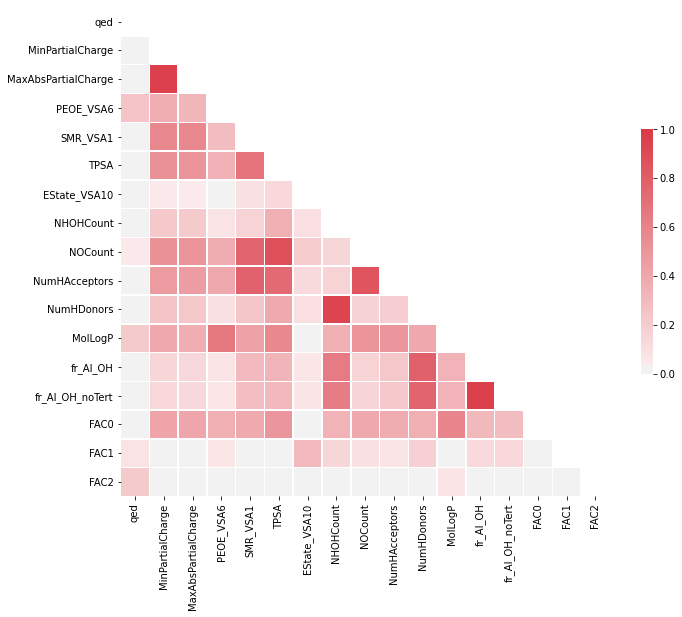

In [75]:
ax, corr = compute_corr(df_rdkit)

Variables space projected on the first principle component (FAC0) shows strong correlation with **logP** and **TPSA** (Topological polar surface area).   

The second principle component (FAC1) shows some correlation with the EState_VSA10 and the number of **H-bond acceptors and Donors**.

It seems that the colloborative filtering model learned something about molecular polarity and basic chemical concepts!


In [76]:
corr['FAC0'].sort_values(ascending=False)

FAC0                   1.000000e+00
MolLogP                6.002239e-01
TPSA                   5.035388e-01
MinPartialCharge       4.231362e-01
MaxAbsPartialCharge    4.074169e-01
NOCount                4.009380e-01
SMR_VSA1               3.881399e-01
NumHAcceptors          3.751594e-01
NumHDonors             3.648076e-01
PEOE_VSA6              3.623790e-01
NHOHCount              3.359465e-01
fr_Al_OH               3.092490e-01
fr_Al_OH_noTert        2.892210e-01
qed                    2.696957e-02
EState_VSA10           1.967952e-03
FAC2                   7.288461e-15
FAC1                   5.085565e-16
Name: FAC0, dtype: float64

In [77]:
corr['FAC1'].sort_values(ascending=False)

FAC1                   1.000000e+00
EState_VSA10           3.010945e-01
NumHDonors             1.808664e-01
NHOHCount              1.489846e-01
fr_Al_OH_noTert        1.384980e-01
fr_Al_OH               1.297483e-01
NOCount                9.068335e-02
qed                    8.447308e-02
NumHAcceptors          7.801174e-02
PEOE_VSA6              6.740623e-02
TPSA                   2.230087e-02
SMR_VSA1               1.719035e-02
MolLogP                2.867912e-03
MinPartialCharge       1.778389e-04
MaxAbsPartialCharge    4.117874e-06
FAC2                   5.845118e-15
FAC0                   5.085565e-16
Name: FAC1, dtype: float64